# Data investigation

In [1]:
!pip install -q transformers evaluate

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DATA_ROOT = '/kaggle/input/sms-spam-collection-dataset/'
file_name = 'spam.csv'

In [4]:
dataframe = pd.read_csv(DATA_ROOT + file_name, encoding='latin-1')

In [5]:
dataframe = dataframe.loc[:, ~dataframe.columns.str.contains('^Unnamed')]
dataframe = dataframe.rename(columns = {'v1':'class', 'v2':'text'})
dataframe

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


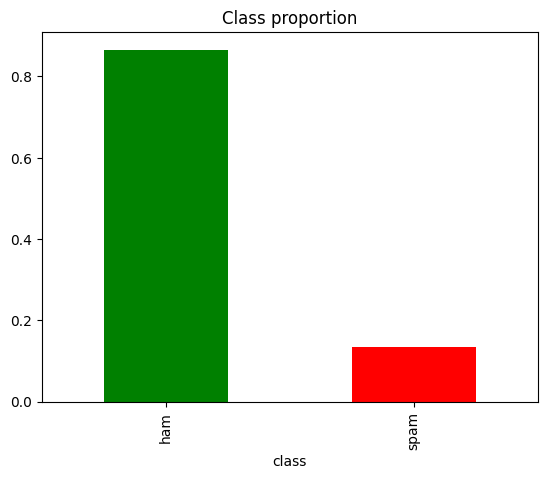

In [6]:
class_prop = dataframe['class'].value_counts(normalize=True, sort=True)
class_prop.plot(kind = 'bar',color = ["green","red"])
plt.title('Class proportion')
plt.show()
plt.close()

In [7]:
label2id = {
    'ham': 0,
    'spam': 1
}
dataframe['label'] = dataframe['class'].apply(lambda x: label2id[x])
class_weights = (1 - dataframe['class'].value_counts(normalize=True, sort=True)).values
class_weights

array([0.13406317, 0.86593683])

In [8]:
dataframe['text_length'] = dataframe['text'].apply(lambda x: len(x.split()))
dataframe.to_csv(path_or_buf='/kaggle/working/spam_fixed.csv')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


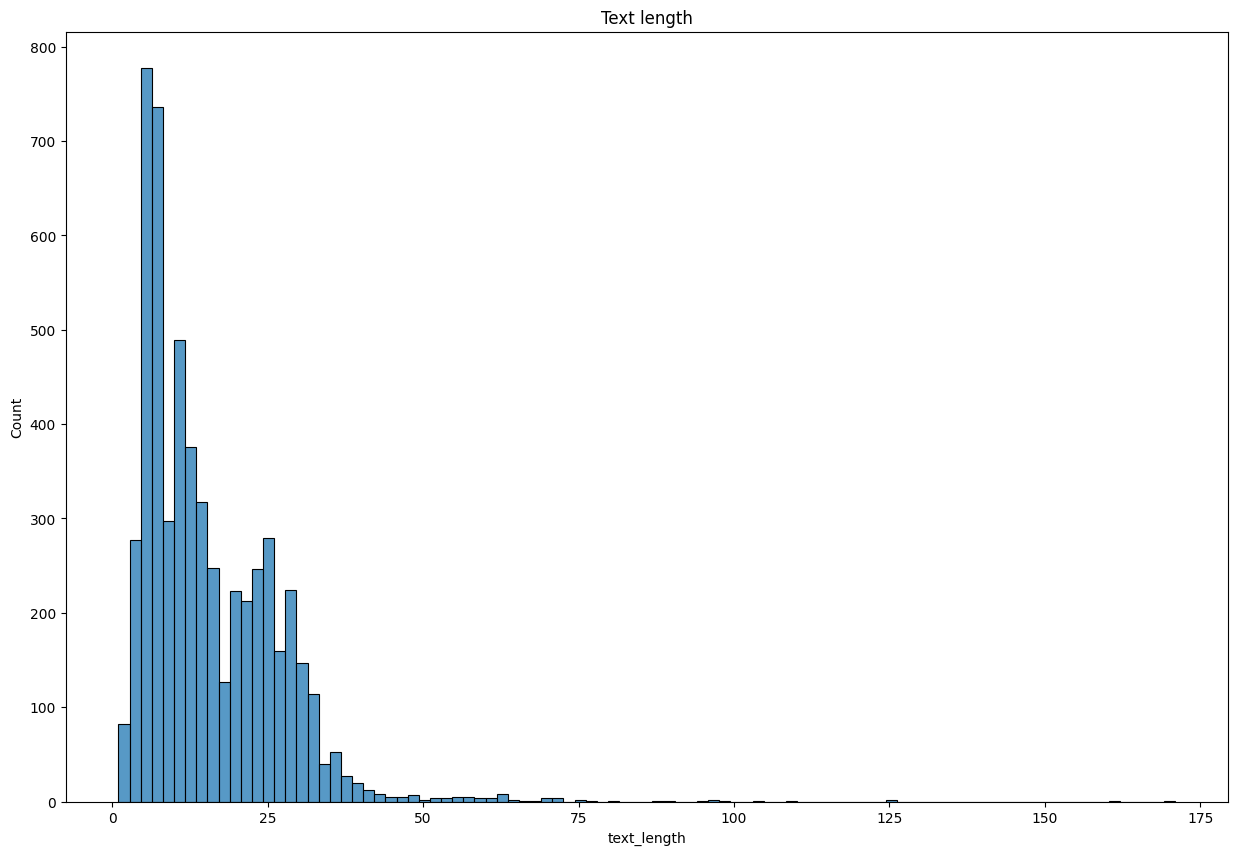

171


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.histplot(data=dataframe['text_length'])
plt.title('Text length')
plt.show()
plt.close()

print(dataframe['text_length'].max())

# Dataset preparation with tokenizer

In [12]:
train_data, val_data = train_test_split(dataframe, test_size=0.2, random_state=42, stratify=dataframe['label'])
train_data.to_csv(path_or_buf='/kaggle/working/spam_fixed_train.csv')
val_data.to_csv(path_or_buf='/kaggle/working/spam_fixed_val.csv')

In [13]:
from transformers import BertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('distilbert/distilbert-base-uncased')


def tokenize_data(data, max_length=256):
    texts = data['text'].tolist()
    tokens = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return tokens


train_tokens = tokenize_data(train_data)
val_tokens = tokenize_data(val_data)
print(train_tokens.input_ids.shape)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


torch.Size([4457, 256])


In [14]:
train_dataset = TensorDataset(
    train_tokens['input_ids'],
    train_tokens['attention_mask'],
    torch.tensor(train_data['label'].tolist(), dtype=torch.long),
)

val_dataset = TensorDataset(
    val_tokens['input_ids'],
    val_tokens['attention_mask'],
    torch.tensor(val_data['label'].tolist(), dtype=torch.long),
)